In [1]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix
import copy

In [2]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

feature_dim = 4
num_classes = 3

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": 3,
    "kappa_join": 2,
    "S_0": 1e-8,
    "N_r": 8,
    "c_max": 1000,
    "device": device
}
federated_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": 10,
    "kappa_join": 10,
    "S_0": 1e-8,
    "N_r": 8,
    "c_max": 1000,
    "device": device
}

PyTorch Version: 2.1.2
CUDA Version: 11.8
CUDA is available. Using GPU.


In [3]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 4
num_splits = 5
num_repetitions = 10

# Re-inserting the repetition of the experiment 10 times
experiment_results = []
for experiment in range(num_repetitions):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)

    # Initialize arrays to track samples per class for each client in each fold
    samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

    # Main loop for k-fold cross-validation
    all_client_metrics = [[] for _ in range(num_clients)]
    all_client_clusters = [[] for _ in range(num_clients)]

    all_federated_metrics = []
    all_federated_clusters = []

    for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
        # Split the data
        train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)

        # Create the models
        local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
        federated_model = eGAUSSp(**federated_model_params)

        # Train and test the models
        for client_idx, client_model in enumerate(local_models):
            # Count the number of samples per class for this client in this fold
            for class_idx in range(client_model.num_classes):
                class_samples = torch.sum((train_data[client_idx][1] == class_idx).float(), dim=0)
                samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

            # Supervised clustering
            train_supervised(client_model, train_data[client_idx])

            # Test the local models
            _, pred, _ = test_model(client_model, test_data)
            metrics = calculate_metrics(pred.cpu(), test_data, "weighted")
            all_client_metrics[client_idx].append(metrics)

            # Save the number of clusters
            num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).cpu()
            all_client_clusters[client_idx].append(num_client_clusters)

        # Aggregate local models
        for client_model in local_models:
            federated_model.federal_agent.merge_model_privately(client_model, federated_model.kappa_n, 0)
        
        aggregated_model = copy.deepcopy(federated_model)
        federated_model.federal_agent.federated_merging()
        federated_model.score = torch.ones_like(federated_model.score)
        federated_model.num_pred = torch.zeros_like(federated_model.num_pred)

        num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0).cpu()
        all_federated_clusters.append(num_federated_clusters)

        # Test the federated model
        _, pred_fed, _ = test_model(federated_model, test_data)
        federated_metrics = calculate_metrics(pred_fed.cpu(), test_data, "weighted")
        all_federated_metrics.append(federated_metrics)

    # Store results of each experiment
    experiment_results.append({
        "client_metrics": all_client_metrics,
        "client_clusters": all_client_clusters,
        "federated_metrics": all_federated_metrics,
        "federated_clusters": all_federated_clusters,
        "samples_per_class_per_client": samples_per_class_per_client
    })
    
# Displaying the result of the first experiment for brevity
experiment_results[0]  # Replace with desired processing or analysis of experiment results


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3017, device='cuda:0')
Updated var_glo values: tensor(0.6821, device='cuda:0')
Updated var_glo values: tensor(0.6348, device='cuda:0')
Updated var_glo values: tensor(0.6820, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.1620, device='cuda:0')
Updated var_glo values: tensor(0.6688, device='cuda:0')
Updated var_glo values: tensor(0.6443, device='cuda:0')
Updated var_glo values: tensor(0.6462, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4760, device='cuda:0')
Updated var_glo values: tensor(0.7833, device='cuda:0')
Updated var_glo values: tensor(0.7190, device='cuda:0')
Updated var_glo values: tensor(0.6956, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4904, device='cuda:0')
Updated var_glo values: tensor(0.7234, device='cuda:0')
Updated var_glo values: tensor(0.7078, device='cuda:0')
Updated var_glo values: tensor(0.6854, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4248, device='cuda:0')
Updated var_glo values: tensor(0.5804, device='cuda:0')
Updated var_glo values: tensor(0.6600, device='cuda:0')
Updated var_glo values: tensor(0.6879, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3088, device='cuda:0')
Updated var_glo values: tensor(0.6442, device='cuda:0')
Updated var_glo values: tensor(0.6486, device='cuda:0')
Updated var_glo values: tensor(0.6527, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2881, device='cuda:0')
Updated var_glo values: tensor(0.7565, device='cuda:0')
Updated var_glo values: tensor(0.6379, device='cuda:0')
Updated var_glo values: tensor(0.6653, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4046, device='cuda:0')
Updated var_glo values: tensor(0.7816, device='cuda:0')
Updated var_glo values: tensor(0.6695, device='cuda:0')
Updated var_glo values: tensor(0.6895, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.6827, device='cuda:0')
Updated var_glo values: tensor(0.7724, device='cuda:0')
Updated var_glo values: tensor(0.6947, device='cuda:0')
Updated var_glo values: tensor(0.6916, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3355, device='cuda:0')
Updated var_glo values: tensor(0.5801, device='cuda:0')
Updated var_glo values: tensor(0.6827, device='cuda:0')
Updated var_glo values: tensor(0.7017, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4459, device='cuda:0')
Updated var_glo values: tensor(1.0142, device='cuda:0')
Updated var_glo values: tensor(0.7532, device='cuda:0')
Updated var_glo values: tensor(0.7333, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4829, device='cuda:0')
Updated var_glo values: tensor(0.8271, device='cuda:0')
Updated var_glo values: tensor(0.6906, device='cuda:0')
Updated var_glo values: tensor(0.6953, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4515, device='cuda:0')
Updated var_glo values: tensor(0.8147, device='cuda:0')
Updated var_glo values: tensor(0.7513, device='cuda:0')
Updated var_glo values: tensor(0.7164, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2833, device='cuda:0')
Updated var_glo values: tensor(0.6610, device='cuda:0')
Updated var_glo values: tensor(0.6133, device='cuda:0')
Updated var_glo values: tensor(0.5761, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.6358, device='cuda:0')
Updated var_glo values: tensor(0.7840, device='cuda:0')
Updated var_glo values: tensor(0.6492, device='cuda:0')
Updated var_glo values: tensor(0.6753, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2490, device='cuda:0')
Updated var_glo values: tensor(0.5941, device='cuda:0')
Updated var_glo values: tensor(0.6879, device='cuda:0')
Updated var_glo values: tensor(0.6993, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3730, device='cuda:0')
Updated var_glo values: tensor(0.7896, device='cuda:0')
Updated var_glo values: tensor(0.6799, device='cuda:0')
Updated var_glo values: tensor(0.6840, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4862, device='cuda:0')
Updated var_glo values: tensor(0.8455, device='cuda:0')
Updated var_glo values: tensor(0.7881, device='cuda:0')
Updated var_glo values: tensor(0.7134, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2492, device='cuda:0')
Updated var_glo values: tensor(0.6948, device='cuda:0')
Updated var_glo values: tensor(0.5981, device='cuda:0')
Updated var_glo values: tensor(0.6096, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5197, device='cuda:0')
Updated var_glo values: tensor(0.8109, device='cuda:0')
Updated var_glo values: tensor(0.6402, device='cuda:0')
Updated var_glo values: tensor(0.6949, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3682, device='cuda:0')
Updated var_glo values: tensor(0.7670, device='cuda:0')
Updated var_glo values: tensor(0.7125, device='cuda:0')
Updated var_glo values: tensor(0.7539, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3291, device='cuda:0')
Updated var_glo values: tensor(0.7849, device='cuda:0')
Updated var_glo values: tensor(0.6806, device='cuda:0')
Updated var_glo values: tensor(0.6683, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.7146, device='cuda:0')
Updated var_glo values: tensor(0.9150, device='cuda:0')
Updated var_glo values: tensor(0.6728, device='cuda:0')
Updated var_glo values: tensor(0.6876, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5081, device='cuda:0')
Updated var_glo values: tensor(0.7387, device='cuda:0')
Updated var_glo values: tensor(0.6341, device='cuda:0')
Updated var_glo values: tensor(0.6304, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3411, device='cuda:0')
Updated var_glo values: tensor(0.6491, device='cuda:0')
Updated var_glo values: tensor(0.6606, device='cuda:0')
Updated var_glo values: tensor(0.6592, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2979, device='cuda:0')
Updated var_glo values: tensor(0.6891, device='cuda:0')
Updated var_glo values: tensor(0.6218, device='cuda:0')
Updated var_glo values: tensor(0.6428, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.1924, device='cuda:0')
Updated var_glo values: tensor(0.5661, device='cuda:0')
Updated var_glo values: tensor(0.6068, device='cuda:0')
Updated var_glo values: tensor(0.6505, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2944, device='cuda:0')
Updated var_glo values: tensor(0.6478, device='cuda:0')
Updated var_glo values: tensor(0.6748, device='cuda:0')
Updated var_glo values: tensor(0.7097, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3479, device='cuda:0')
Updated var_glo values: tensor(0.7890, device='cuda:0')
Updated var_glo values: tensor(0.6609, device='cuda:0')
Updated var_glo values: tensor(0.6921, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3913, device='cuda:0')
Updated var_glo values: tensor(0.7858, device='cuda:0')
Updated var_glo values: tensor(0.7678, device='cuda:0')
Updated var_glo values: tensor(0.7097, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3747, device='cuda:0')
Updated var_glo values: tensor(0.6997, device='cuda:0')
Updated var_glo values: tensor(0.7323, device='cuda:0')
Updated var_glo values: tensor(0.7265, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2554, device='cuda:0')
Updated var_glo values: tensor(0.7706, device='cuda:0')
Updated var_glo values: tensor(0.7027, device='cuda:0')
Updated var_glo values: tensor(0.6525, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3861, device='cuda:0')
Updated var_glo values: tensor(0.6857, device='cuda:0')
Updated var_glo values: tensor(0.7085, device='cuda:0')
Updated var_glo values: tensor(0.6906, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2083, device='cuda:0')
Updated var_glo values: tensor(0.7341, device='cuda:0')
Updated var_glo values: tensor(0.6469, device='cuda:0')
Updated var_glo values: tensor(0.6989, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4991, device='cuda:0')
Updated var_glo values: tensor(0.8606, device='cuda:0')
Updated var_glo values: tensor(0.6464, device='cuda:0')
Updated var_glo values: tensor(0.6333, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4828, device='cuda:0')
Updated var_glo values: tensor(0.7467, device='cuda:0')
Updated var_glo values: tensor(0.6524, device='cuda:0')
Updated var_glo values: tensor(0.7267, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3817, device='cuda:0')
Updated var_glo values: tensor(0.7022, device='cuda:0')
Updated var_glo values: tensor(0.6642, device='cuda:0')
Updated var_glo values: tensor(0.6509, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5086, device='cuda:0')
Updated var_glo values: tensor(0.7147, device='cuda:0')
Updated var_glo values: tensor(0.6575, device='cuda:0')
Updated var_glo values: tensor(0.6583, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2700, device='cuda:0')
Updated var_glo values: tensor(0.7419, device='cuda:0')
Updated var_glo values: tensor(0.6918, device='cuda:0')
Updated var_glo values: tensor(0.7171, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3743, device='cuda:0')
Updated var_glo values: tensor(0.6715, device='cuda:0')
Updated var_glo values: tensor(0.6892, device='cuda:0')
Updated var_glo values: tensor(0.6502, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5572, device='cuda:0')
Updated var_glo values: tensor(0.6803, device='cuda:0')
Updated var_glo values: tensor(0.6487, device='cuda:0')
Updated var_glo values: tensor(0.7155, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4376, device='cuda:0')
Updated var_glo values: tensor(0.6863, device='cuda:0')
Updated var_glo values: tensor(0.6816, device='cuda:0')
Updated var_glo values: tensor(0.7113, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3778, device='cuda:0')
Updated var_glo values: tensor(0.7871, device='cuda:0')
Updated var_glo values: tensor(0.6648, device='cuda:0')
Updated var_glo values: tensor(0.6452, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3103, device='cuda:0')
Updated var_glo values: tensor(0.7321, device='cuda:0')
Updated var_glo values: tensor(0.6267, device='cuda:0')
Updated var_glo values: tensor(0.6458, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3734, device='cuda:0')
Updated var_glo values: tensor(0.5836, device='cuda:0')
Updated var_glo values: tensor(0.6390, device='cuda:0')
Updated var_glo values: tensor(0.6860, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5580, device='cuda:0')
Updated var_glo values: tensor(0.8894, device='cuda:0')
Updated var_glo values: tensor(0.7904, device='cuda:0')
Updated var_glo values: tensor(0.7206, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3209, device='cuda:0')
Updated var_glo values: tensor(0.6472, device='cuda:0')
Updated var_glo values: tensor(0.6280, device='cuda:0')
Updated var_glo values: tensor(0.6234, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4558, device='cuda:0')
Updated var_glo values: tensor(0.7173, device='cuda:0')
Updated var_glo values: tensor(0.6801, device='cuda:0')
Updated var_glo values: tensor(0.6750, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5279, device='cuda:0')
Updated var_glo values: tensor(0.8581, device='cuda:0')
Updated var_glo values: tensor(0.7557, device='cuda:0')
Updated var_glo values: tensor(0.6833, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3905, device='cuda:0')
Updated var_glo values: tensor(0.6715, device='cuda:0')
Updated var_glo values: tensor(0.6821, device='cuda:0')
Updated var_glo values: tensor(0.6982, device='cuda:0')
Evolving has been disabled.


{'client_metrics': [[{'accuracy': 0.5333333333333333,
    'precision': 0.36363636363636365,
    'recall': 0.5333333333333333,
    'f1_score': 0.40888888888888886},
   {'accuracy': 0.7,
    'precision': 0.6222222222222222,
    'recall': 0.7,
    'f1_score': 0.644039270687237},
   {'accuracy': 0.6666666666666666,
    'precision': 0.5181818181818182,
    'recall': 0.6666666666666666,
    'f1_score': 0.5647058823529411},
   {'accuracy': 0.6,
    'precision': 0.42,
    'recall': 0.6,
    'f1_score': 0.4842105263157895},
   {'accuracy': 0.6333333333333333,
    'precision': 0.47536231884057967,
    'recall': 0.6333333333333333,
    'f1_score': 0.5231746031746032}],
  [{'accuracy': 0.7333333333333333,
    'precision': 0.6,
    'recall': 0.7333333333333333,
    'f1_score': 0.6444444444444444},
   {'accuracy': 0.7333333333333333,
    'precision': 0.5555555555555555,
    'recall': 0.7333333333333333,
    'f1_score': 0.6266666666666667},
   {'accuracy': 0.6,
    'precision': 0.375,
    'recall': 0

In [4]:
import numpy as np

# Initialize variables to store aggregated data
agg_client_metrics = [{} for _ in range(num_clients)]
agg_federated_metrics = {}
agg_client_clusters = [[] for _ in range(num_clients)]
agg_federated_clusters = []

# Process each experiment
for result in experiment_results:
    for client_idx, client_metrics in enumerate(result['client_metrics']):
        for metric in client_metrics[0].keys():
            if metric not in agg_client_metrics[client_idx]:
                agg_client_metrics[client_idx][metric] = []
            agg_client_metrics[client_idx][metric].extend([m[metric] for m in client_metrics])

    for metric in result['federated_metrics'][0].keys():
        if metric not in agg_federated_metrics:
            agg_federated_metrics[metric] = []
        agg_federated_metrics[metric].extend([m[metric] for m in result['federated_metrics']])

    for client_idx, client_clusters in enumerate(result['client_clusters']):
        agg_client_clusters[client_idx].extend(client_clusters)

    agg_federated_clusters.extend(result['federated_clusters'])

# Calculate averages and standard deviations
for client_metrics in agg_client_metrics:
    for metric, values in client_metrics.items():
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        client_metrics[metric] = (mean, std)

for metric, values in agg_federated_metrics.items():
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    agg_federated_metrics[metric] = (mean, std)

# Example of printing aggregated metrics for the first client
print("Aggregated Metrics for Client 1:")
for metric, (mean, std) in agg_client_metrics[0].items():
    print(f"{metric}: {mean:.2f} ± {std:.2f}")

agg_samples = np.zeros((num_clients, num_classes, num_splits))

# Aggregate data from each experiment
for result in experiment_results:
    samples_per_class_per_client = result['samples_per_class_per_client']
    agg_samples += samples_per_class_per_client

# Compute the average across all repetitions (and folds if required)
avg_samples = agg_samples / len(experiment_results)

# Calculate the average for each client and class across folds
avg_samples_per_class_per_client = avg_samples.mean(axis=2)

# Print the results
for client_idx in range(num_clients):
    print(f"Client {client_idx + 1}:")
    for class_idx in range(num_classes):
        avg_samples = avg_samples_per_class_per_client[client_idx, class_idx]
        print(f"  Class {class_idx}: {avg_samples:.2f} samples")

Aggregated Metrics for Client 1:
accuracy: 0.59 ± 0.09
precision: 0.46 ± 0.10
recall: 0.59 ± 0.09
f1_score: 0.49 ± 0.10
Client 1:
  Class 0: 0.00 samples
  Class 1: 9.96 samples
  Class 2: 10.06 samples
Client 2:
  Class 0: 19.90 samples
  Class 1: 0.00 samples
  Class 2: 10.18 samples
Client 3:
  Class 0: 10.06 samples
  Class 1: 19.64 samples
  Class 2: 10.20 samples
Client 4:
  Class 0: 10.04 samples
  Class 1: 10.40 samples
  Class 2: 9.56 samples


In [5]:
# Create a LaTeX table for the paper
# Start the LaTeX table code
latex_table = r"""\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
"""

# Add the header for average samples per class
latex_table += r"Average Samples &"

# Add the average samples per class for each client
samples_row = ""
for samples in avg_samples_per_class_per_client:
    samples_row += " & " + "/".join([f"{x:.1f}" for x in samples])
latex_table += samples_row + " \\\\" + "\n"

latex_table += r"\midrule" + "\n"


# Add rows for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy (\%)', 'Precision (\%)', 'Recall (\%)', 'F1 Score (\%)']
for i, metric in enumerate(metrics):
    row = metric_names[i] + r' $\uparrow$'
    for client_metrics in agg_client_metrics:
        mean, std = client_metrics[metric]
        row += f' & {mean * 100:.1f} ± {std * 100:.1f}'
    mean, std = agg_federated_metrics[metric]
    row += r' & \bf' + f'{{{mean * 100:.1f} ± {std * 100:.1f}}}'
    latex_table += row + r' \\' + '\n'

# Add row for clusters
cluster_row = r'\#Clusters $\downarrow$'
for client_clusters in agg_client_clusters:
    avg_clusters = np.mean(client_clusters)
    std_clusters = np.std(client_clusters, ddof=1)
    cluster_row += f' & {avg_clusters:.1f} ± {std_clusters:.1f}'

# Assuming agg_federated_clusters is a list of cluster counts for the federated model
avg_fed_clusters = np.mean(agg_federated_clusters)
std_fed_clusters = np.std(agg_federated_clusters, ddof=1)
cluster_row += r' & \bf' + f'{{{avg_fed_clusters:.1f} ± {std_fed_clusters:.1f}}}'

latex_table += cluster_row + r' \\' + '\n'

# End the LaTeX table code
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the complete LaTeX table
print(latex_table)


\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
Average Samples & & 0.0/10.0/10.1 & 19.9/0.0/10.2 & 10.1/19.6/10.2 & 10.0/10.4/9.6 \\
\midrule
Accuracy (\%) $\uparrow$ & 58.9 ± 9.3 & 66.5 ± 7.9 & 89.9 ± 6.0 & 89.1 ± 7.1 & \bf{96.2 ± 3.8} \\
Precision (\%) $\uparrow$ & 45.5 ± 10.0 & 49.4 ± 9.5 & 91.9 ± 4.5 & 91.4 ± 4.9 & \bf{96.7 ± 3.2} \\
Recall (\%) $\uparrow$ & 58.9 ± 9.3 & 66.5 ± 7.9 & 89.9 ± 6.0 & 89.1 ± 7.1 & \bf{96.2 ± 3.8} \\
F1 Score (\%) $\uparrow$ & 49.4 ± 10.0 & 55.3 ± 9.4 & 89.6 ± 6.5 & 88.8 ± 7.5 & \bf{96.2 ± 3.8} \\
\#Clusters $\downarrow$ & 4.6 ± 1.2 & 3.5 ± 0.9 & 6.9 ± 1.5 & 6.5 ± 1.5 & \bf{3.0 ± 0.0} \\
\bottomrule
\end{tabular}
\end{table}



Client 1: {1: 8, 2: 12}
Client 2: {0: 23, 2: 7}
Client 3: {0: 10, 1: 18, 2: 12}
Client 4: {0: 9, 1: 13, 2: 8}
Test Set: {0: 8, 1: 11, 2: 11}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150
Figure saved as .Images/iris_data_distribution.svg in svg format.


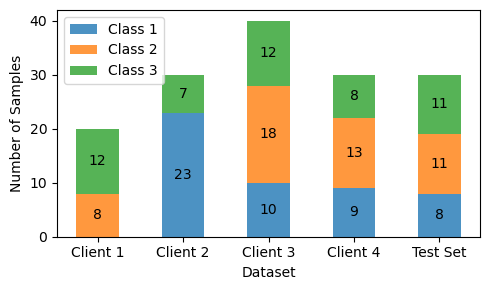

In [6]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, ".Images/iris_data_distribution.svg","svg")

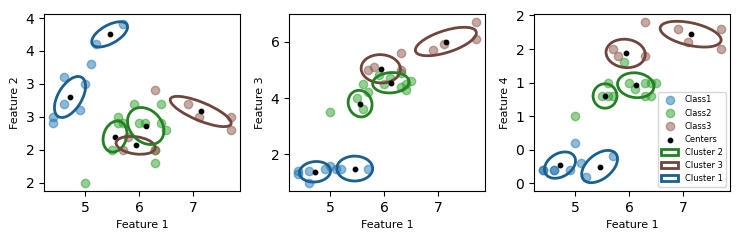

Figure saved as .Images/iris_local_model.svg in svg format.
Figure saved as .Images/iris_local_model.pdf in pdf format.


In [7]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="",format='%d', legend = True, data_name = "Class")  
save_figure(fig, ".Images/iris_local_model.svg", "svg")
save_figure(fig, ".Images/iris_local_model.pdf","pdf")

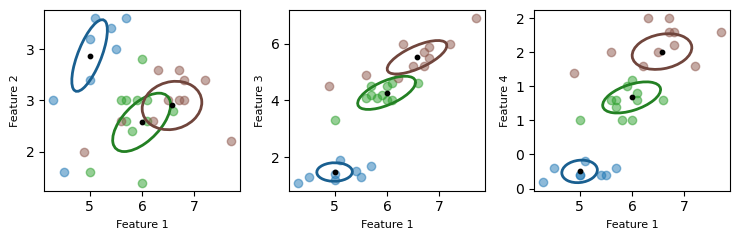

Number of clusters after merging = 3
Figure saved as .Images/iris_federated_merged.svg in svg format.
Figure saved as .Images/iris_federated_merged.pdf in pdf format.


In [8]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model.cpu(), num_sigma=2, N_max=0, title="", format='%d')   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, ".Images/iris_federated_merged.svg","svg")
save_figure(fig, ".Images/iris_federated_merged.pdf","pdf")

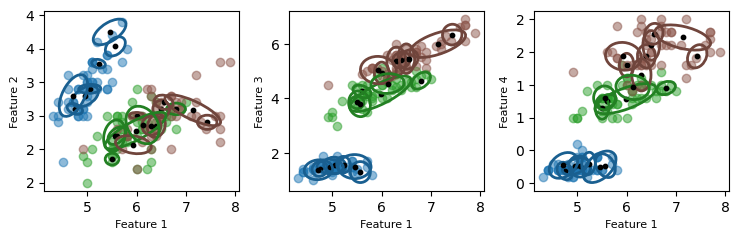

Figure saved as .Images/iris_aggregated.svg in svg format.
Figure saved as .Images/iris_aggregated.pdf in pdf format.


In [9]:
#Plot of the last aggregated model
fig = plot_first_feature_horizontal(all_data, model= aggregated_model.cpu(), num_sigma=2, N_max=0, title="", format='%d')   
save_figure(fig, ".Images/iris_aggregated.svg","svg")
save_figure(fig, ".Images/iris_aggregated.pdf","pdf")

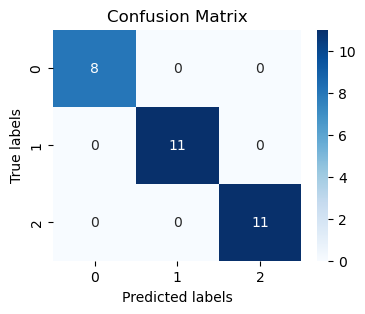

In [10]:
plot_confusion_matrix(pred_fed.cpu(), test_data)